# Preamble

In [1]:
%load_ext autoreload
%autoreload 2

# disable parallelization for BLAS and co.
from nalabtools.utils.parallelization import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)

# general
import re
import collections
import pickle

# data
import numpy as np
import pandas as pd

# ml / stats
import sklearn
import statsmodels.stats.multitest

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nalab
import nalabtools

# init notebook files
import nalabtools.utils.misc
nb = nalabtools.utils.misc.NotebookContext("martin_001_deepinsight")

# Load data

In [2]:
import h5py
file = h5py.File('../data/deepinsight/dataset2.mat', "r")

In [45]:
X_main_raw = file["dset"]["Xtrain"][...]
X_test_raw = file["dset"]["Xtest"][...]

In [46]:
y_main = np.repeat([0,1], file["dset"]["num_tr"][...].flatten().astype(np.int))
y_test = np.repeat([0,1], file["dset"]["num_tst"][...].flatten().astype(np.int))

In [47]:
print(X_main_raw.shape, y_main.shape, X_test_raw.shape, y_test.shape)

(6660, 20) (6660,) (740, 20) (740,)


In [57]:
splits = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.05).split(X_main_raw, y_main)
train_idx, val_idx = next(splits)
X_train_raw = X_main_raw[train_idx, :]
y_train = y_main[train_idx]
X_val_raw = X_main_raw[val_idx, :]
y_val = y_main[val_idx]

# Normalization

In [58]:
preprocessing = sklearn.preprocessing.MinMaxScaler().fit(X_train_raw)
X_train = preprocessing.transform(X_train_raw)
X_val = preprocessing.transform(X_val_raw)
X_test = preprocessing.transform(X_test_raw)

# Derive images and dataset

In [59]:
import butterfly.deepinsight.album2

In [60]:
at = butterfly.deepinsight.album2.AlbumTransformer(40)
at.fit(X_train)
X_train_album = at.transform_parallel(X_train, n_jobs=None)

In [61]:
X_val_album = at.transform_parallel(X_val, n_jobs=None)
X_test_album = at.transform_parallel(X_test, n_jobs=None)

In [62]:
import torch.utils.data
dataset_train = butterfly.deepinsight.album2.AlbumDataset(X_train_album[:,[1],:,:], y_train)
dataset_val = butterfly.deepinsight.album2.AlbumDataset(X_val_album[:,[1],:,:], y_val)
dataset_test = butterfly.deepinsight.album2.AlbumDataset(X_test_album[:,[1],:,:], y_test)

In [71]:
bs = 64
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=bs, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=bs * 2)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=bs * 2)

# Network

In [64]:
import torch.optim as optim
import butterfly.deepinsight.deepinsight
from tqdm import tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter



In [ ]:
writer = SummaryWriter(nb.folder('runs/exp4'))

In [65]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

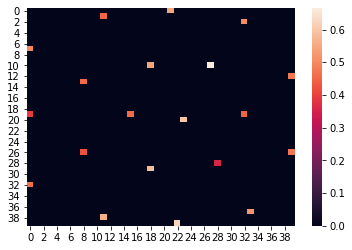

In [129]:
sns.heatmap(X_train_album[0,1,:])

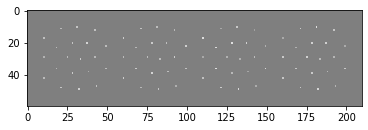

In [128]:
img_grid = torchvision.utils.make_grid(torch.from_numpy(X_train_album[:4,[1],:,:]), padding=10)

writer.add_image('test_image', img_grid)
matplotlib_imshow(img_grid)

In [70]:
import butterfly.deepinsight.deepinsight
m = butterfly.deepinsight.deepinsight.DeepInsight(
    input_dim=X_train_album.shape[2:],
    kernel_size1=1, kernel_size2=2, n_initial_filters=1)


dataiter = iter(dataloader_train)
images, labels = dataiter.next()

writer.add_graph(m, images[:4,:])
writer.flush()

In [37]:
# # embeddings
# # Bugfix: https://github.com/pytorch/pytorch/issues/30966
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# features = images.view(-1, 40 * 40)
# writer.add_embedding(features,
#                     metadata=labels,
#                     label_img=images.unsqueeze(1))
# writer.close()

In [72]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(m.parameters(), lr=0.001, momentum=0.9, )
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)

pbar = tqdm(range(100))
for epoch in pbar:  # loop over the dataset multiple times

    m.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = m(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        every = 30
        if i % every == every - 1:
            
            m.eval()
            
            with torch.no_grad():
                loss_val = sum(criterion(m(x), y) for x, y in dataloader_val)
                loss_val /= len(dataloader_val)
                
            loss_train = running_loss / every
            writer.add_scalars("loss", dict(train=loss_train, validation=loss_val), epoch * len(dataloader_train) + i)
            running_loss = 0.0
            
            pbar.set_description(f"Processing [epoch={epoch}, batch={i:2d}] training_loss={running_loss / every:.03f}")
            
            m.train()
        
            
print('Finished Training')

Processing [epoch=99, batch=89] training_loss=0.000: 100%|██████████| 100/100 [04:56<00:00,  2.97s/it]

Finished Training


# TODOS
- [x] visualize validation loss
- [x] visualize images ... everyhting else in the tensorboard tutorial
- [ ] get AFCS files and run the first single cell thingy


In [73]:
y_pred_proba = m(torch.tensor(X_train_album[:,[1],:,:]).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
sklearn.metrics.accuracy_score(y_pred, y_train)

0.960328749802434

In [74]:
y_pred_proba = m(torch.tensor(X_test_album[:,[1],:,:]).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
sklearn.metrics.accuracy_score(y_pred, y_test)

0.9540540540540541

In [75]:
import sklearn.ensemble
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(X_train_raw, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
sklearn.metrics.accuracy_score(rf.predict(X_train_raw), y_train)

1.0

In [77]:
sklearn.metrics.accuracy_score(rf.predict(X_test_raw), y_test)

0.9581081081081081